# Project: Write a Data Science Blog Post

## Section 1: Business Understanding
For this project, I was interestested in using Seattle AirBNB data from 2016 to better understand:

### Question 1: How much of seasonality premiums are there in AirBNB rentals?

### Question 2: What proportion of AirBNB rentals charge seasonality premium?

### Question 3: What factors if any have correlations with seasonality premiums?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

In [3]:
from datetime import datetime, date, time

In [48]:
import textwrap as tw # needed to wrap around pie chart labels that are too long

In [4]:
# remove display limits for columns and rows
pd.options.display.max_columns = None # default is 20
pd.options.display.max_rows = None # default is 60
# alternative
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)


## Section 2: Data Understanding

#### Gather data

In [7]:
# read in Seattle AirBNB data from https://www.kaggle.com/datasets/airbnb/seattle
df_cal = pd.read_csv(r'\\healthfilesvr01\users$\ipark\Udacity\data science nano\seattle airbnb\calendar.csv')
df_list = pd.read_csv(r'\\healthfilesvr01\users$\ipark\Udacity\data science nano\seattle airbnb\listings.csv')
df_reviews = pd.read_csv(r'\\healthfilesvr01\users$\ipark\Udacity\data science nano\seattle airbnb\reviews.csv')

In [8]:
# shapes of data sets
print(df_cal.shape)
print(df_list.shape)
print(df_reviews.shape)

(1393570, 4)
(3818, 92)
(84849, 6)


## Section 3: Prepare Data

### Add a boolean column to filter out listings with available days less than 70% of the year that would be considered seasonal hosts

In [9]:
#add a new column to df_cal that converts the string 'available' column to a boolean data to compute available days % by listing_id
df_cal['avail_bool'] = (df_cal['available']=='t')

In [10]:
# available days by listing_id in 2016
df_avail_percent = df_cal[['listing_id','avail_bool']].groupby(['listing_id']).mean()

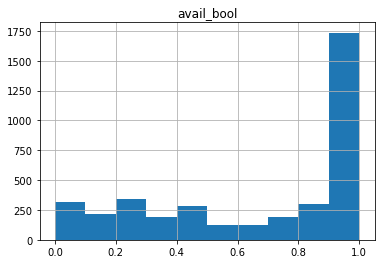

In [11]:
#histogram of df_aval_percent
df_avail_percent.hist();

**Above histogram shows the largest group of the listings had avaibility 90% or more. We choose the listings with 70% or more availability for our analysis**

In [12]:
# filter pricing data for listing_ids with rental available days 70% or more in 2016 because we need the data of hosts 
# that have presence throughout the year for seaonality pricing comparison.
# listing_ids with 70 plus availability
avail_70 = df_avail_percent[df_avail_percent['avail_bool'] >=.7].reset_index()

In [13]:
# filter out listing_ids with available days % below 70%
df_cal_70 = df_cal[df_cal['listing_id'].isin(avail_70['listing_id'])].copy()

### Add additional columns and functions to label each listing for weekends and summer

In [14]:
# add day of week name to identify weekend pricing
df_cal_70['day_name'] = pd.to_datetime(df_cal_70['date']).dt.day_name()

In [15]:
# add month in numeric to identify summer months
df_cal_70['month']=pd.to_datetime(df_cal_70['date']).dt.month

In [16]:
# to test if day_name column was populated properly
df_cal_70['day_name'].isin(['Friday','Saturday']).mean()

0.28493150684931506

In [77]:
# This function looks at day name of each listing and return boolean results. 
# This is needed to understand pricings by weekend and weekdays
def weekend_day(df):
    '''
    INPUT
    df - A DataFrame Series of day name you want to go through and determine if it's a weekend day or a weekday
    
    OUTPUT
    the function returns True if a weekend day and False otherwise.
    '''
    return df.isin(['Friday','Saturday'])    

In [82]:
# This function looks at month expressed in integer of each listing and return boolean results. 
# This is needed to understand pricings by summer and non_summer
def summer_months(df):
    '''
    INPUT
    df - A DataFrame Series of a numeric month you want to go through and determine if it's a summer month or not
    
    OUTPUT
    the function returns True if a summer month and False otherwise.
    '''    
    return df.isin([6,7,8])

In [85]:
df_cal_70['wknd'] = weekend_day(df_cal_70['day_name'])

In [87]:
df_cal_70['summer'] = summer_months(df_cal_70['month'])

**The following two cells are a altervative way to add wknd and summer column without creating functions**

In [17]:
#create a bolean column for weekend days
df_cal_70['wknd']=df_cal_70.apply(lambda x: (x.day_name in ['Friday','Saturday']), axis=1)

In [18]:
#create a bolean column for summer months
df_cal_70['summer']=df_cal_70.apply(lambda x: (x.month in [6,7,8]), axis=1)

In [19]:
#convert string price to a float type for calculation
df_cal_70['price']=df_cal_70['price'].replace('[\$,]','',regex=True).astype(float)

In [88]:
# test one listing id to see if the new columns added have data populated properly
df_cal_70[df_cal_70['listing_id']==3884805]

,listing_id,date,available,price,avail_bool,day_name,month,wknd,summer
995355,3884805,2016-01-04,f,NaN,False,Monday,1,False,False
995356,3884805,2016-01-05,f,NaN,False,Tuesday,1,False,False
995357,3884805,2016-01-06,f,NaN,False,Wednesday,1,False,False
995358,3884805,2016-01-07,f,NaN,False,Thursday,1,False,False
995359,3884805,2016-01-08,f,NaN,False,Friday,1,True,False
995360,3884805,2016-01-09,t,88.0,True,Saturday,1,True,False
995361,3884805,2016-01-10,t,150.0,True,Sunday,1,False,False
995362,3884805,2016-01-11,t,150.0,True,Monday,1,False,False
995363,3884805,2016-01-12,t,150.0,True,Tuesday,1,False,False
995364,3884805,2016-01-13,t,150.0,True,Wednesday,1,False,False


### Checking key statistics

In [21]:
#summer months price avg
df_cal_70[df_cal_70['month'].isin([6,7,8])]['price'].mean()

146.86472845960893

In [22]:
#non summer months price avg
df_cal_70[~df_cal_70['month'].isin([6,7,8])]['price'].mean()

133.24184269894266

In [23]:
#all months price avg
df_cal_70['price'].mean()

136.79154378711814

In [24]:
#summer price premium % over non summer months
df_cal_70[df_cal_70['month'].isin([6,7,8])]['price'].mean()/df_cal_70[~df_cal_70['month'].isin([6,7,8])]['price'].mean() -1

0.10224179945819944

In [25]:
#avg wknd price
df_cal_70[df_cal_70['wknd']==True]['price'].mean()

141.92373449469943

In [26]:
#avg weekday price
df_cal_70[df_cal_70['wknd']==False]['price'].mean()

134.7570487584948

In [27]:
#weekend price premium %
df_cal_70[df_cal_70['wknd']==True]['price'].mean()/df_cal_70[df_cal_70['wknd']==False]['price'].mean() - 1

0.05318226988666419

**As expected, weekend and summer prices are higher than weekday and non summer months**

### Create a pivot table to get summary data by listing id

In [28]:
# create pivot table of summer price average by listing id
df_cal_summer=pd.pivot_table(df_cal_70,values='price',index='listing_id',columns=['summer'],aggfunc=np.mean)

In [29]:
# rename column names
df_cal_summer=df_cal_summer.rename(columns={False:'non_summer',True:'summer'})

In [30]:
# create pivot table of weekend price average by listing id
df_cal_wknd=pd.pivot_table(df_cal_70,values='price',index='listing_id',columns=['wknd'],aggfunc=np.mean)

In [31]:
# rename column names
df_cal_wknd=df_cal_wknd.rename(columns={False:'non_wknd',True:'wknd'})

### Using Merger method pull in data fields from df_list table that may be correlated to how hosts determine seasonality premium.

In [32]:
# merge df_cal_summer and df_cal_wknd tables
df_cal_summary=pd.merge(df_cal_summer,df_cal_wknd,on="listing_id")

In [33]:
# head of df_cal_summary
df_cal_summary.head()

,non_summer,summer,non_wknd,wknd
listing_id,,,,
3335,120.000000,120.000000,120.000000,120.000000
4291,82.000000,82.000000,82.000000,82.000000
5682,51.377880,60.000000,53.675676,54.632184
6606,92.857143,92.826087,90.000000,100.000000
9419,83.186813,92.826087,83.563218,90.769231


In [34]:
# pull in additional data from df_list table that may have bearings on the pricing for correation analysis
df_cal_summary=pd.merge(df_cal_summary,df_list[['id','neighbourhood','latitude','longitude','host_listings_count','accommodates','bathrooms','beds','price', \
                                 'guests_included','minimum_nights']],how='left',left_on="listing_id",right_on='id') 

In [35]:
# add a column of summer premium by listing id
df_cal_summary['summer_prem']=df_cal_summary['summer']/df_cal_summary['non_summer']-1

In [36]:
# average summer premium
df_cal_summary['summer_prem'].mean()

0.08665245929557697

In [37]:
# add a column of weekend premium by listing id
df_cal_summary['wknd_prem']=df_cal_summary['wknd']/df_cal_summary['non_wknd']-1

In [38]:
# average wknd premium
df_cal_summary['wknd_prem'].mean()

0.060396206700042226

In [39]:
# drop nan rows from numeric data columns for correcation analysis
df_cal_no_nan = df_cal_summary.dropna(subset=['host_listings_count','accommodates','bathrooms','beds','price', \
                                 'guests_included','minimum_nights'])

In [40]:
# create a sub dataframe with numerica data column for correlation analysis
df_cal_stat=df_cal_no_nan[['wknd_prem','host_listings_count','accommodates','bathrooms','beds','price', \
                                 'guests_included','minimum_nights']]

In [41]:
df_cal_summary.head()

,non_summer,summer,non_wknd,wknd,id,neighbourhood,latitude,longitude,host_listings_count,accommodates,bathrooms,beds,price,guests_included,minimum_nights,summer_prem,wknd_prem
0,120.000000,120.000000,120.000000,120.000000,3335,Dunlap,47.529846,-122.275840,4.0,4,1.0,2.0,$120.00,2,2,0.000000,0.000000
1,82.000000,82.000000,82.000000,82.000000,4291,Roosevelt,47.687251,-122.313130,6.0,2,1.0,1.0,$82.00,1,2,0.000000,0.000000
2,51.377880,60.000000,53.675676,54.632184,5682,South Delridge,47.523980,-122.359891,1.0,2,1.0,1.0,$48.00,1,3,0.167818,0.017820
3,92.857143,92.826087,90.000000,100.000000,6606,Wallingford,47.654109,-122.337605,3.0,2,1.0,1.0,$90.00,2,2,-0.000334,0.111111
4,83.186813,92.826087,83.563218,90.769231,9419,Georgetown,47.550620,-122.320135,5.0,2,3.0,1.0,$90.00,1,2,0.115875,0.086234


## Section 4: Evaluation

### Question 1: How much of seasonality premiums are there in AirBNB rentals?

#### Analysis 1: Plot a line chart of daily average price of rentals in 2016 regardless having seasonal premium or not

In [89]:
# create a Series of daily average price 
df_avg_price_by_date=df_cal_70.groupby('date')['price'].mean()

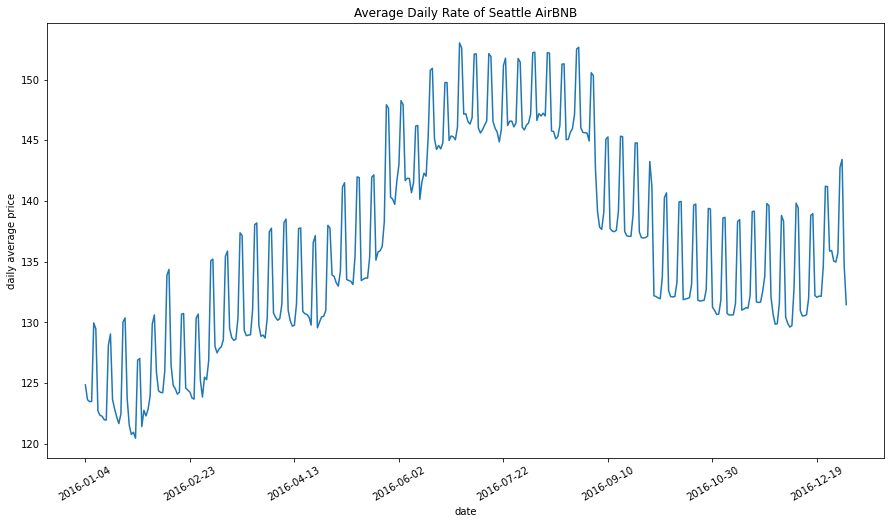

In [90]:
# plot a line chart
df_avg_price_by_date.plot.line(rot=30,figsize=(15,8),ylabel='daily average price',title='Average Daily Rate of Seattle AirBNB');

**The plot has numberous peaks and valleys which represent price difference of weekend vs weekday. Going across calendar months, high averages on summer months are very distinct**

#### Analysis 2: Plot a line chart of daily average price of rentals in 2016 that have summer premium.

In [59]:
# the following 2 cells are for preparation of line plot of average daily pricing of the listings with summer premium
# create a series of average daily price of summer months
df_avg_price_summer_prem_summer=df_cal_70[   (df_cal_70['listing_id'].isin(df_cal_summary[df_cal_summary['summer_prem']>0]['id'])) & \
                                (df_cal_70['summer']==True)].groupby('date')['price'].mean()

In [60]:
# create a series of average daily price of non_summer months
df_avg_price_summer_prem_nonsummer=df_cal_70[   (df_cal_70['listing_id'].isin(df_cal_summary[df_cal_summary['summer_prem']>0]['id'])) & \
                                (df_cal_70['summer']==False)].groupby('date')['price'].mean()

In [61]:
# summer premium charged by hosts that charge summer premium
df_avg_price_summer_prem_summer.mean()/df_avg_price_summer_prem_nonsummer.mean()

1.246834693051882

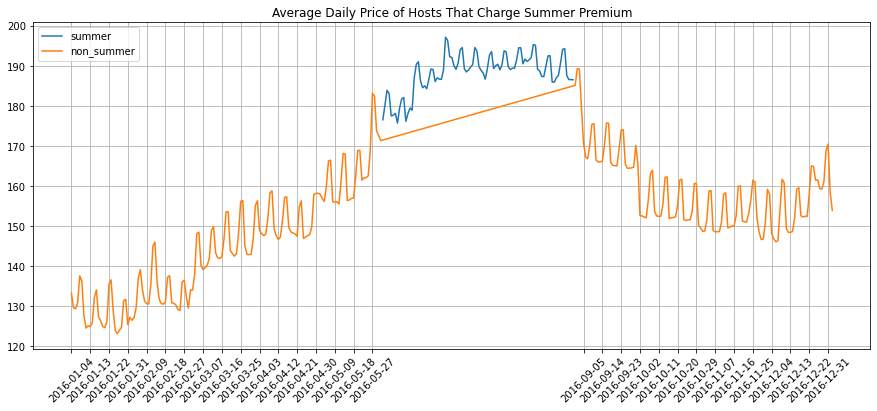

In [62]:
# plotting average daily price of listings that charge summer premium
fig,axes=plt.subplots(1,1, figsize=(15,6))
x=pd.to_datetime(df_avg_price_summer_prem_summer.index).date
y=df_avg_price_summer_prem_summer.values
axes.plot(x,y,label='summer')
x=pd.to_datetime(df_avg_price_summer_prem_nonsummer.index).date
y=df_avg_price_summer_prem_nonsummer.values
axes.plot(x,y, label='non_summer')
axes.set_title('Average Daily Price of Hosts That Charge Summer Premium')
#plt.xlim(pd.to_datetime(['2016-08-01','2016-12-15']))
axes.set_xticks(x[::9])
axes.set_xticklabels(x[::9],rotation=45)
plt.legend(loc="upper left")
plt.grid()
plt.show()

**Summer-month prices in this chart seem more elevated than the one on from the line chart with all hosts presented before this chart**

#### Analysis 3: Plot a line chart of daily average price of rentals in 2016 that have weekend premium.

In [64]:
# the following 2 cells are for preparation of line plot of average daily pricing of the listings with weekend premium
# create a series of average daily price of weekend days
df_avg_price_wknd_prem_wknd=df_cal_70[   (df_cal_70['listing_id'].isin(df_cal_summary[df_cal_summary['wknd_prem']>0]['id'])) & \
                                (df_cal_70['wknd']==True)].groupby('date')['price'].mean()

In [65]:
# create a series of average daily price of weekdays
df_avg_price_wknd_prem_wkday=df_cal_70[   (df_cal_70['listing_id'].isin(df_cal_summary[df_cal_summary['wknd_prem']>0]['id'])) & \
                                (df_cal_70['wknd']==False)].groupby('date')['price'].mean()

In [66]:
# weekend premium charged by hosts that charge weekend premium
df_avg_price_wknd_prem_wknd.mean()/df_avg_price_wknd_prem_wkday.mean()

1.1075462663052598

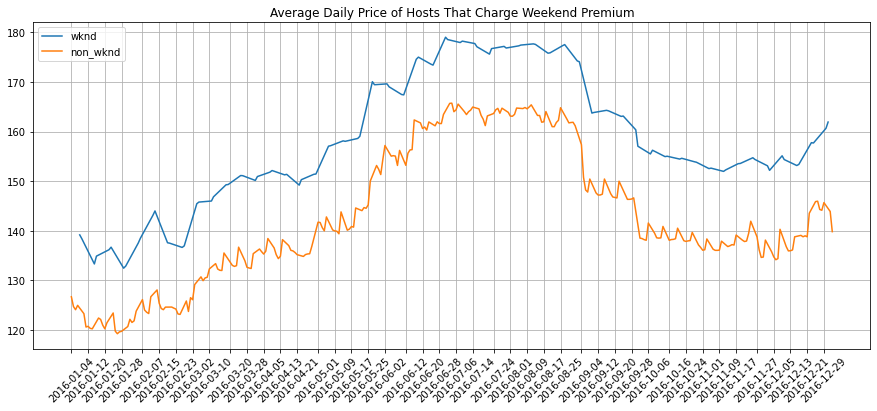

In [67]:
# plotting average daily price of listings that charge weekend premium
fig,axes=plt.subplots(1,1, figsize=(15,6))
x=pd.to_datetime(df_avg_price_wknd_prem_wknd.index).date
y=df_avg_price_wknd_prem_wknd.values
axes.plot(x,y,label='wknd')
x=pd.to_datetime(df_avg_price_wknd_prem_wkday.index).date
y=df_avg_price_wknd_prem_wkday.values
axes.plot(x,y, label='non_wknd')
axes.set_title('Average Daily Price of Hosts That Charge Weekend Premium')
#plt.xlim(pd.to_datetime(['2016-08-01','2016-12-15']))
axes.set_xticks(x[::6])
axes.set_xticklabels(x[::6],rotation=45)
plt.legend(loc="upper left")
plt.grid()
plt.show()

**The plot shows the average price of weekends are clearly higher than the one of weekdays throughout the year.**

### Question 2: What proportion of AirBNB rentals charge seasonality premium?

#### Analysis: Plot pie charts to show proportions of listings with or without seasonality premium

In [50]:
# following six cells are for preparation toward the pie chart that follows
# number of hosts that charge less for weekend rental 
a=df_cal_summary[df_cal_summary['wknd_prem']<0].shape[0]

In [51]:
# number of hosts that do not charge more for weekend rental 
b=df_cal_summary[df_cal_summary['wknd_prem']==0].shape[0]

In [52]:
# number of hosts that do charge more for weekend rental
c=df_cal_summary[df_cal_summary['wknd_prem']>0].shape[0]

In [53]:
# number of hosts that do not charge more for summer rental 
e=df_cal_summary[df_cal_summary['summer_prem']<0].shape[0]

In [54]:
# number of hosts that do not charge more for summer rental 
f=df_cal_summary[df_cal_summary['summer_prem']==0].shape[0]

In [55]:
# number of hosts that do charge more for summer rental 
g=df_cal_summary[df_cal_summary['summer_prem']>0].shape[0]

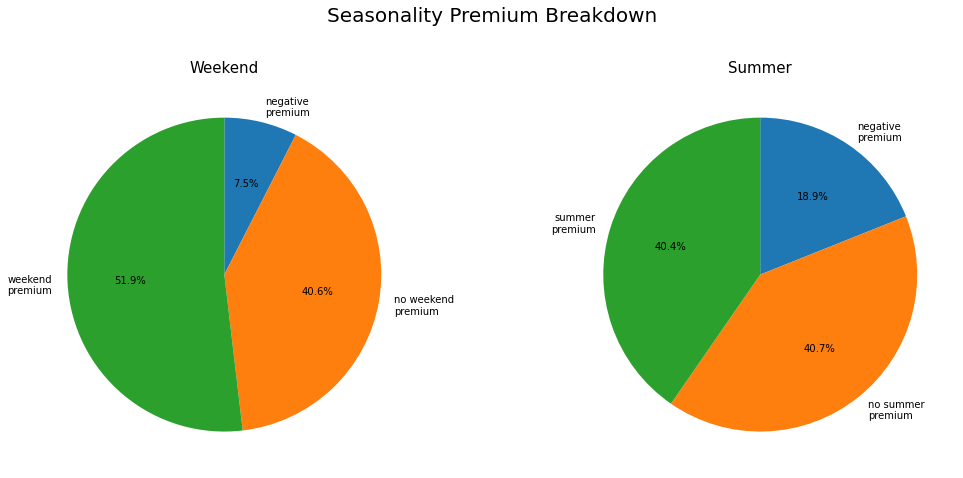

In [56]:
# pie chart to see breakdown of listings with seasonality premiums that are positive, zero, and negative
fig,ax=plt.subplots(1,2, figsize=(15,6))
wknd_prem_pct=[a,b,c]
wknd_labels = ['negative premium','no weekend premium','weekend premium']
wknd_labels = [ '\n'.join(tw.wrap(l, 10)) for l in wknd_labels ]
#wknd_prem_pct.index=['gen5','gen1','gen3']
ax[0].pie(wknd_prem_pct,labels=wknd_labels,startangle=90, autopct='%1.1f%%', 
        counterclock=False);
ax[0].set_title('Weekend',fontsize=15)
summer_prem_pct=[e,f,g]
#wknd_prem_pct.index=['gen5','gen1','gen3']
summer_labels = ['negative premium','no summer premium','summer premium']
summer_labels = [ '\n'.join(tw.wrap(l, 10)) for l in summer_labels ]
ax[1].pie(summer_prem_pct,labels=summer_labels,startangle=90, autopct='%1.1f%%',
        counterclock=False);
ax[1].set_title('Summer',fontsize=15)
fig.tight_layout()
plt.suptitle('Seasonality Premium Breakdown',y=1.1,fontsize=20)
plt.show() #show all figures

**Only about a half of the hosts charged more for weekend rental and about 40% did for summer rental. The rest of the hosts didn’t apply premium rates for weekends or summer. Some even charged lower for weekends or summer. The percent of hosts with no seasonality rate or reverse seasonality was quite higher than expected.**

### Question 3: What factors if any have correlations with seasonality premiums?                        

#### Analysis 1: Is there any correlation between seasonality premium % and other numerical attributes like host_listings_count, accommodates, bathroom count, bed count, rental price, number of guests_included, number of minimum_nights?  
**Utlized a paired scatter plot and heatmap from Seaborn to test the degree of correlation**

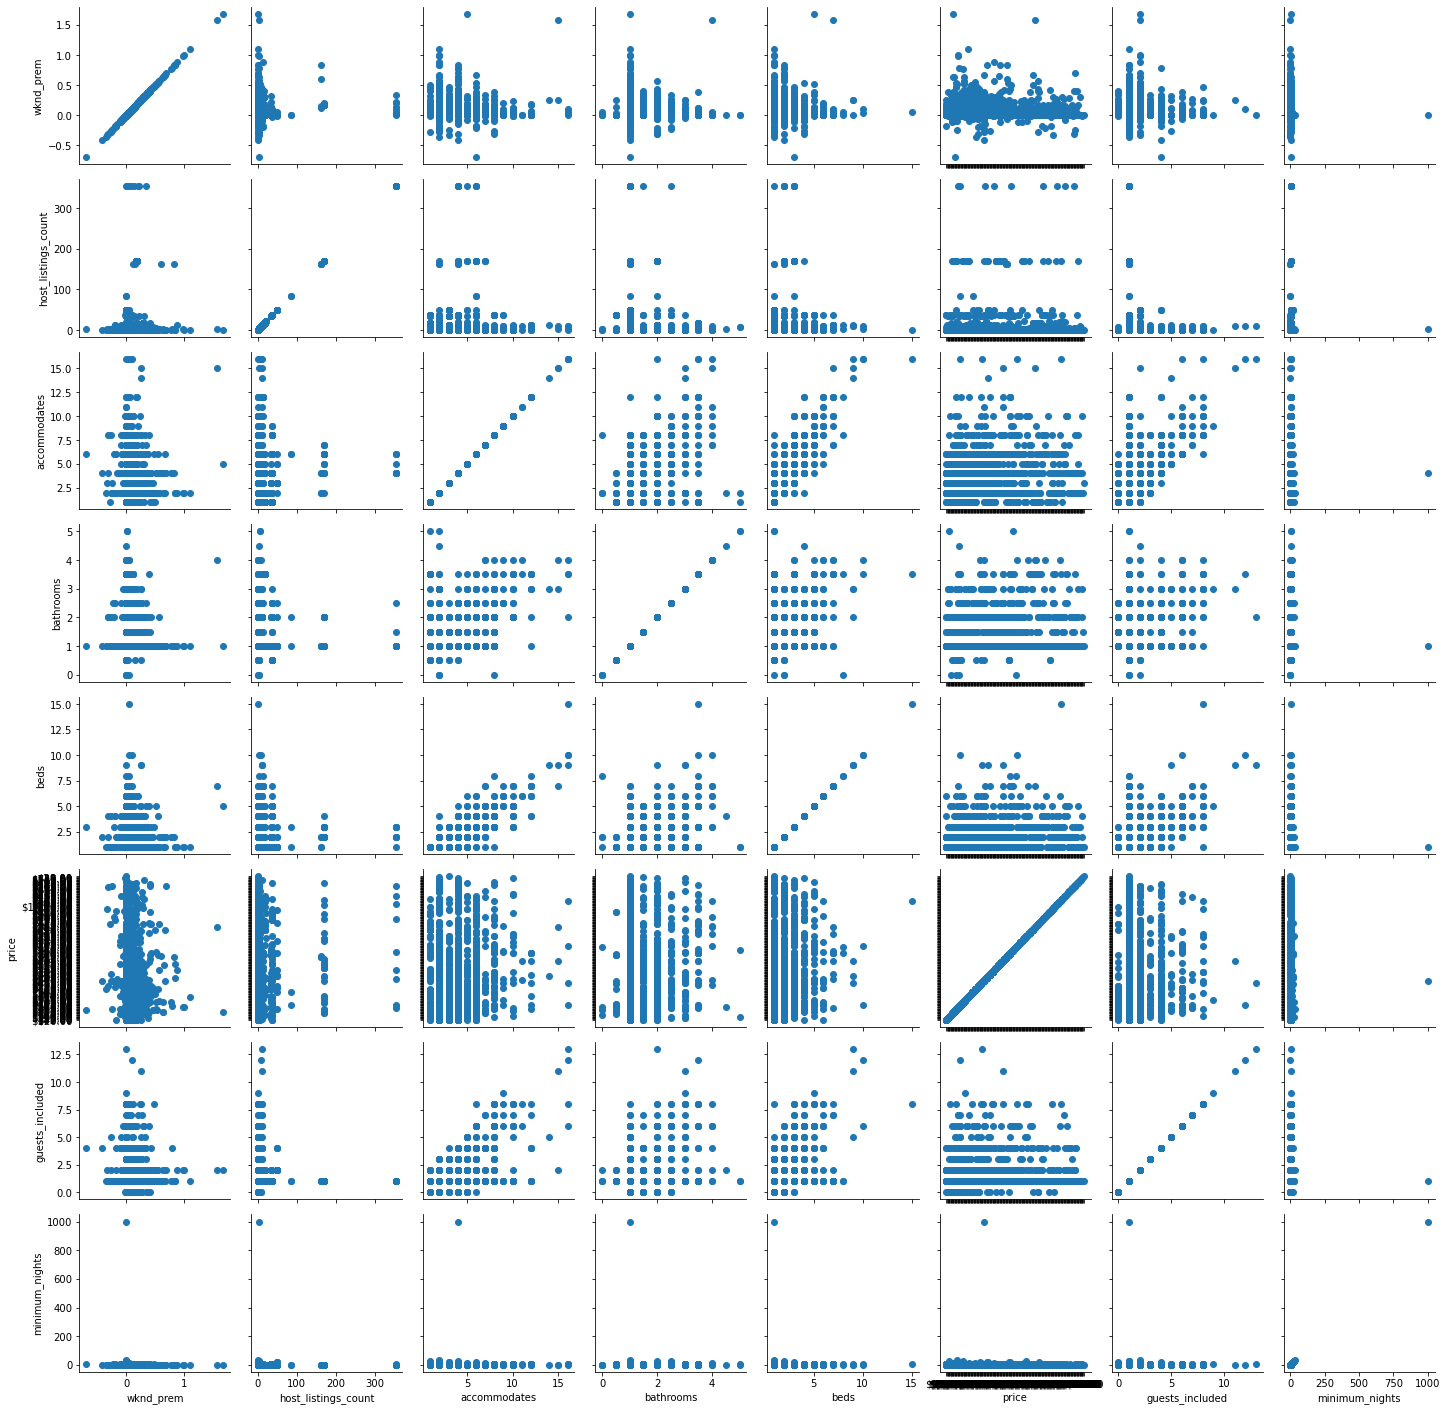

In [42]:
# scatter plot for correlation amongst numerica data. no strong correlation was noted between pricing and other 
# numeric columns
var_columns = ['wknd_prem','host_listings_count','accommodates','bathrooms','beds','price', \
                                 'guests_included','minimum_nights']
g=sns.PairGrid(data=df_cal_stat,vars=var_columns);
g.map(plt.scatter);

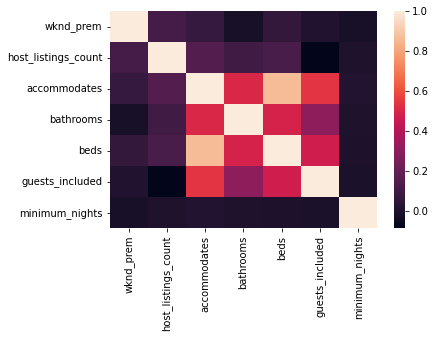

In [43]:
# another version of correlation test
sns.heatmap(df_cal_stat[var_columns].corr());

**No strong/modestly strong correlation was observed from the paired scatter plot or heatmap**

#### Analysis 2: Is seasonality premium higher/lower in certain geographical location?

**Plotted premium % against geographical locations using longitude and latitude**

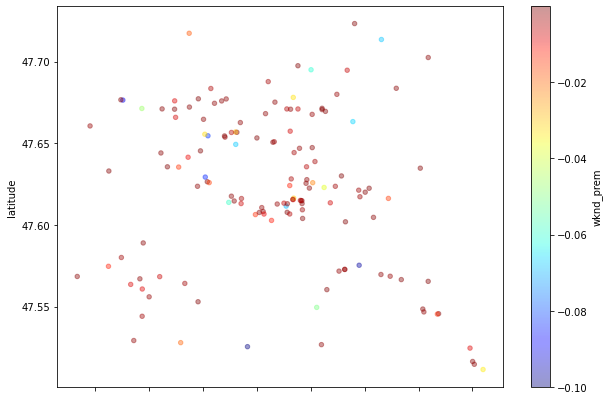

In [44]:
# scatter plot to see if rentals with negative weekend premium are concentrated in certain geographical locations
# plot was limited to the weekend premium range between -0.1 and 0 where the most negative premiums were seen.
# the scatter plot shows no geographical concentration of negative premium
df_cal_summary[(df_cal_summary['wknd_prem']>-0.1) & (df_cal_summary['wknd_prem']<0)].plot(kind="scatter", x="longitude", y="latitude",
    #s=housing['population']/100, label="population",
    c="wknd_prem", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
#plt.legend()
plt.show()

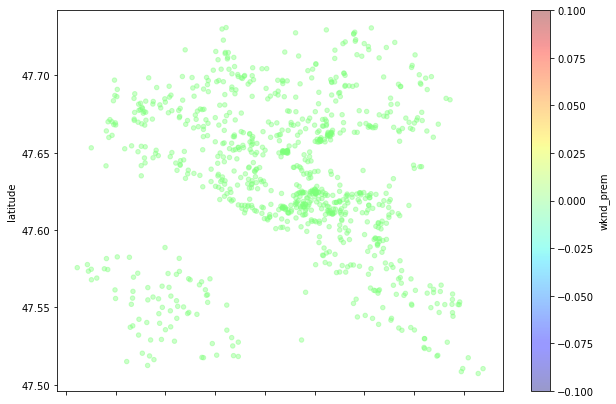

In [45]:
# scatter plot to see if rentals with no weekend premium are concentrated in certain geographical locations
# the scatter plot shows no geographical concentration of zero weekend premium
df_cal_summary[df_cal_summary['wknd_prem']==0].plot(kind="scatter", x="longitude", y="latitude",
    #s=housing['population']/100, label="population",
    c="wknd_prem", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
#plt.legend()
plt.show()

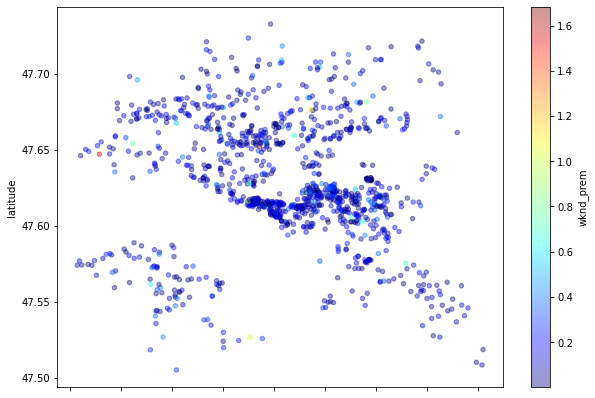

In [46]:
# scatter plot to see if rentals with positive weekend premium are concentrated in certain geographical locations
# the scatter plot shows no geographical concentration of positive weekend premium
df_cal_summary[df_cal_summary['wknd_prem']>0].plot(kind="scatter", x="longitude", y="latitude",
    #s=housing['population']/100, label="population",
    c="wknd_prem", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7),
)
#plt.legend()
plt.show()

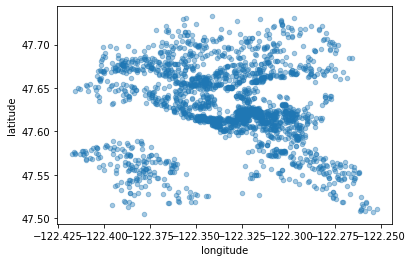

In [47]:
# overall scatter plot of the rentals's geo location
df_cal_summary.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4)
plt.show()

**The scatterplots show that seasonality premium %'s of certain range (i.e. high or low premium %) aren't concentrated in any geographical locations**

## The following cells are side analysis that aren't meant for the audience. Feel free to explore at your own risks. :)

**Average weekend premium by neighborhood - I wanted to see which neighborhoods have higher weekend premium**

In [71]:
# average weekend premium by neighborhood
df_cal_summary.groupby('neighbourhood')['wknd_prem'].mean().sort_values()

neighbourhood
Licton Springs              -0.025776
South Park                  -0.001449
Olympic Hills                0.000000
View Ridge                   0.000000
Roxhill                      0.000000
Riverview                    0.000000
Fairmount Park               0.000000
Laurelhurst                  0.000000
Seaview                      0.000377
Crown Hill                   0.001442
Montlake                     0.003540
Rainier Beach                0.004826
Wedgewood                    0.008113
Alki                         0.012505
Mathews Beach                0.014575
Interbay                     0.016922
Harrison/Denny-Blaine        0.017432
Holly Park                   0.019380
Seward Park                  0.020449
Yesler Terrace               0.021568
Stevens                      0.021908
Dunlap                       0.024712
Pinehurst                    0.027088
Portage Bay                  0.030119
Bitter Lake                  0.030407
Columbia City                0.03270

**The following is a plot showing average daily price of hosts that have reverse weekend premium (i.e. charge more for weekday rental)**

In [81]:
df_avg_price_wknd_disc_wknd=df_cal_70[   (df_cal_70['listing_id'].isin(df_cal_summary[df_cal_summary['wknd_prem']<0]['id'])) & \
                                (df_cal_70['wknd']==True)].groupby('date')['price'].mean()

In [82]:
df_avg_price_wknd_disc_wkday=df_cal_70[   (df_cal_70['listing_id'].isin(df_cal_summary[df_cal_summary['wknd_prem']<0]['id'])) & \
                                (df_cal_70['wknd']==False)].groupby('date')['price'].mean()

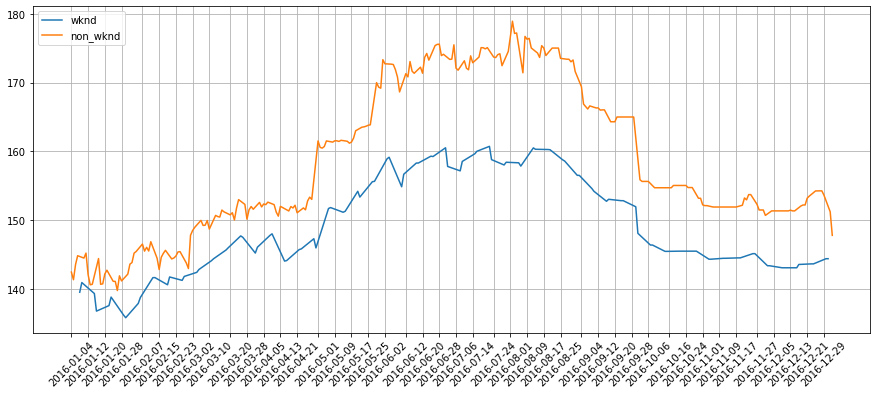

In [83]:
fig,axes=plt.subplots(1,1, figsize=(15,6))
x=pd.to_datetime(df_avg_price_wknd_disc_wknd.index).date
y=df_avg_price_wknd_disc_wknd.values
axes.plot(x,y,label='wknd')
x=pd.to_datetime(df_avg_price_wknd_disc_wkday.index).date
y=df_avg_price_wknd_disc_wkday.values
axes.plot(x,y, label='non_wknd')
#plt.xlim(pd.to_datetime(['2016-08-01','2016-12-15']))
axes.set_xticks(x[::6])
axes.set_xticklabels(x[::6],rotation=45)
plt.legend(loc="upper left")
plt.grid()
plt.show()

**As expected weekday prices (orage line) is trending higher than weekend prices (blue line)**